<img src="./image/Title.png">

### 패키지 import 및 bundle 객체 선언

In [1]:
import cv2
import numpy as np
import modi
import time

Running PyMODI (v1.0.1)


In [2]:
bundle = modi.MODI(ai_mode=True)
ai_cam = bundle.ai_cameras[0]
motor = bundle.motors[0]
print('bundle finish')

Initiating can connection...
Start initializing connected MODI modules
Motor (2352) has been connected!
Ir (2088) has been connected!
Ir (1528) has been connected!
MODI modules are initialized!
MODI AI modules are initialized!
bundle finish


### 선 이미지 출력 함수

In [3]:
def t_display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image

### Canny function
##### 윤곽선 추출

In [4]:
# Canny 이미지 처리함수
def canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, 50, 150)
    return canny

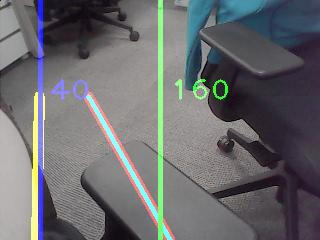

KeyboardInterrupt: 

In [5]:
ai_cam.set_window()
ai_cam.set_frame_height(320)
ai_cam.set_frame_weight(240)
while True:
    frame = ai_cam.read()
    frame = cv2.flip(frame, 1)
    canny_image = canny(frame)
    ai_cam.show(canny_image)

### ROI (Region Of Interest)
##### 영역 설정

In [6]:
# Roi 설정 함수 (카메라 화각이 좁은 관계로 화면 전체를 잡은 상태)
def region_of_interest(image):
    width = image.shape[1]
#     polygons = np.array([[(0,320),(width,320),(width,0),(0,0)]])
    polygons = np.array([[(0,50), (width,50),(width,480),(0,480)]])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

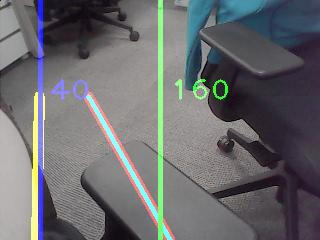

KeyboardInterrupt: 

In [7]:
ai_cam.set_window()
while True:
    frame = ai_cam.read()
    frame = cv2.flip(frame, 1)
    canny_image = canny(frame)
    cropped_image = region_of_interest(canny_image)
    ai_cam.show(cropped_image)

### Hough Lines
##### 직선 추출

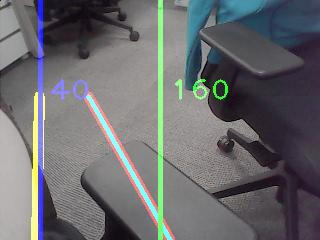

KeyboardInterrupt: 

In [15]:
ai_cam.set_window()
while True:
    frame = ai_cam.read()
    frame = cv2.flip(frame, 1)
    canny_image = canny(frame)
    cropped_image = region_of_interest(canny_image)
    
    lines = cv2.HoughLinesP(cropped_image, 0.8 , np.pi/180, 10, np.array([]), minLineLength=40, maxLineGap=200)
    frame_lines = t_display_lines(frame, lines)
    
    combo_image = cv2.addWeighted(frame, 0.8, frame_lines, 1, 1)
    
    ai_cam.show(combo_image)

### Average Slope
##### 기울기 처리

In [16]:
# 선 좌표 처리함수
def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(2/5))
    
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return np.array([x1, y1, x2, y2])

# 선 기울기 처리함수
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < -0.5:
            left_fit.append((slope, intercept))
        elif 0.5 < slope:
            right_fit.append((slope, intercept))
    if (len(left_fit) != 0):
        left_fit_average = np.average(left_fit, axis=0)
    else:
        left_fit_average = ((-5, 240))
    if (len(right_fit) != 0):
        right_fit_average = np.average(right_fit, axis=0)
    else:
        right_fit_average = ((5, -1360))
    left_line = make_coordinates(image, left_fit_average)
    
    rigth_line = make_coordinates(image, right_fit_average)
    return np.array([left_line, rigth_line])


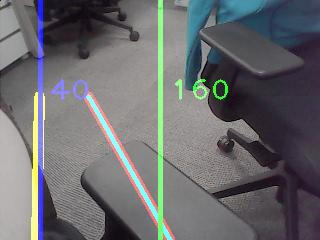

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

KeyboardInterrupt: 

In [18]:

ai_cam.set_window()
while True:
    frame = ai_cam.read()
    frame = cv2.flip(frame, 1)
    canny_image = canny(frame)
    cropped_image = region_of_interest(canny_image)
    
#     lines = cv2.HoughLinesP(cropped_image, 0.7 , np.pi/180, 50, np.array([]), minLineLength=1, maxLineGap=1)
    lines = cv2.HoughLinesP(cropped_image, 0.8 , np.pi/180, 10, np.array([]), minLineLength=100, maxLineGap=200)
    
    if str(type(lines)) == "<class 'NoneType'>":
        lines = [[[0, 0 ,0 ,0]]]
    elif len(lines) < 2:
        continue

    # 선분이 2개 검출될때 실행 
    if len(lines) >= 2 :
        averaged_lines = average_slope_intercept(frame, lines)
            
        frame_lines = t_display_lines(frame, averaged_lines)

        combo_image = cv2.addWeighted(frame, 0.8, frame_lines, 1, 1)

        ai_cam.show(combo_image)

### Find Vanishing
##### 소실점 추출

In [19]:
# 중심 축과 검출된 선들의 중심축 좌표 출력 함수 
def find_vanishing(image, lines):
    
    x11, y11, x12, y12 = lines[0]
    cv2.line(image, (x11, y11), (x12, y12), (255, 255, 0), 10)
    x21, y21, x22, y22 = lines[1]
    cv2.line(image, (x21, y21), (x22, y22), (0, 255, 255), 3)
    m1 = (y12 - y11) / (x12 - x11)
    m2 = ((y22 - y21) / (x22 - x21)) -0.001
    cx = int((x11 * m1 - y11 - x21 * m2 + y21) / (m1 - m2))
    center = int(image.shape[1]/2)

    
    cv2.line(image, (cx, 0), (cx, image.shape[0]), (0, 0, 255), 3) 
    cv2.putText(image, str(cx), (cx+10, 100), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
    cv2.line(image, (center, 0), (center, image.shape[0]), (0, 255, 0), 3)
    cv2.putText(image, str(center), (center+10, 100), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)

    return image, cx, center


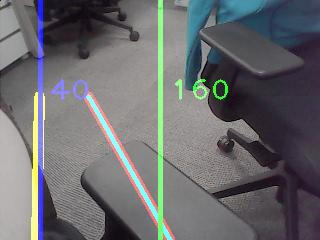

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

KeyboardInterrupt: 

In [20]:
ai_cam.set_window()
while True:
    frame = ai_cam.read()
    frame = cv2.flip(frame, 1)
    canny_image = canny(frame)
    cropped_image = region_of_interest(canny_image)
    
    lines = cv2.HoughLinesP(cropped_image, 0.8 , np.pi/180, 15, np.array([]), minLineLength=40, maxLineGap=200)
    
    if str(type(lines)) == "<class 'NoneType'>":
        lines = [[[0, 0 ,0 ,0]]]
    elif len(lines) < 2:
        continue

    # 선분이 2개 검출될때 실행 
    if len(lines) >= 2 :
        averaged_lines = average_slope_intercept(frame, lines)
        line_image = t_display_lines(frame, averaged_lines)
        vanishing_line, vanishing, center = find_vanishing(line_image, averaged_lines)
        combo_image = cv2.addWeighted(frame, 0.8, vanishing_line, 1, 1)
        ai_cam.show(combo_image)

### 모터 & 차량 제어

In [33]:
# # MODI 모터 제어 함수 
# def forward(delay=1, speed=60):
#     motor.speed= 0, 0
# #     time.sleep(0.001)
#     for _ in range(delay):
# #         time.sleep(0.001)
#         motor.speed= speed, -speed
#         time.sleep(0.001)
#     motor.speed =0, 0

# def left(delay=1):
#     motor.speed= 0,0
# #     time.sleep(0.001)
#     for _ in range(delay):
# #         time.sleep(0.001)
#         motor.speed= 60, 60
#         time.sleep(0.001)
#     motor.speed =0, 0

# def right(delay=1):
#     motor.speed = 0, 0
# #     time.sleep(0.001)
#     for _ in range(delay):
# #         time.sleep(0.001)
#         motor.speed= -60, -60
#         time.sleep(0.001)
#     motor.speed = 0, 0

    
# MODI 모터 제어 함수 
def forward():
    motor.speed= 30, -30
    time.sleep(0.01)
#     motor.speed= 0,0

def left():
    motor.speed= 45, -25
    time.sleep(0.01)
#     motor.speed= 0,0

def right():
    motor.speed = 25, -45
    time.sleep(0.01)
#     motor.speed= 0,0
    
    
# 차량 이동 함수 
def find_way(vanishing, center):
    diff = vanishing - center
    if diff < -20:
        left()
    elif diff > 20:
        right()
    else:
        forward()

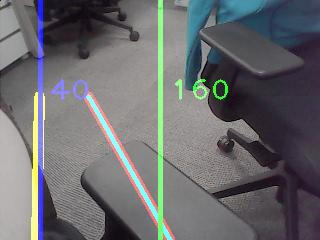

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.p

In [ ]:
ai_cam.set_window()
while True:
    frame = ai_cam.read()
    frame = cv2.flip(frame, 1)
    canny_image = canny(frame)
    cropped_image = region_of_interest(canny_image)
    
    lines = cv2.HoughLinesP(cropped_image, 0.8 , np.pi/180, 15, np.array([]), minLineLength=40, maxLineGap=200)
    
    if str(type(lines)) == "<class 'NoneType'>":
        lines = [[[0, 0 ,0 ,0]]]
    elif len(lines) < 2:
        continue

    # 선분이 2개 검출될때 실행 
    if len(lines) >= 2 :
        averaged_lines = average_slope_intercept(frame, lines)
        line_image = t_display_lines(frame, averaged_lines)
        vanishing_line, vanishing, center = find_vanishing(line_image, averaged_lines)
        combo_image = cv2.addWeighted(frame, 0.8, vanishing_line, 1, 1)
        ai_cam.show(combo_image)
        find_way(vanishing, center)

# 확인 문제

### Open CV 이미지 처리

#### 1. 직선을 1개만 추출하려면 어떻게 해야할까요?
#### 2. canny를 적용하지 않고 나머지 코드를 실행하면 어떤 결과가 나올까요?
#### 3. grayscale을 적용하지 않고 나머지 코드를 실행하면 어떤 결과가 나올까요?

In [26]:
left()